Text Analytics Assignment 3 ( Sentiment Analysis)

##### Imports

In [ ]:
# Installing and checking keras tuner and tensorflow
!pip install -q --upgrade tensorflow
!pip install keras-tuner -q --upgrade

     |████████████████████████████████| 462 kB 5.3 MB/s 
     |████████████████████████████████| 98 kB 3.1 MB/s 


In [ ]:
#Verify Pytorch installation
import torch
print(torch.__version__)

1.10.0+cu111


In [ ]:
# Verify Tensorflow  installation
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
#Necessary Library Imports 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow import keras
import math 
import numpy as np
import os
from sklearn.dummy import DummyClassifier
import pandas as pd
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import WhitespaceTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.metrics import roc_auc_score
import csv
import gzip
import urllib.request
import requests
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Downloading Stopwords & Dictionary
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

#Downloading data(In compressed form) provided by Stanford University
!wget -q  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

#Unzipping data
!tar  xzf aclImdb_v1.tar.gz

In [ ]:
#Setting random seed so we can analyse results
np.random.seed(365)

##### Loading Data

In [ ]:
#Initializing Function to load data
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
          #Renaming sentiment to values 
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])
    #Shuffling train data
    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
     #Shuffling test data
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    return data["train"], data["test"] 

In [ ]:
# Loading the data into train,test
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

In [ ]:
#Combining them together
newdf=pd.concat([train_data,test_data],ignore_index=True)

##### Preprocessing + Learning Curves Function

In [ ]:
#Splitting our dataset into train & test
train_data,test_data = train_test_split(newdf,train_size=0.7,random_state=1)

#Splitting our test set into dev & test 
dev_data,test_data = train_test_split(test_data, test_size =  0.6 ,random_state=1)

#Checking lengths
print('Train length',train_data.shape[0])
print('Dev length',dev_data.shape[0])
print('Test length',test_data.shape[0])

Train length 35000
Dev length 6000
Test length 9000


In [ ]:
#Average train document length
train_data['countWords'] = train_data.text.str.count(' ') + 1
average=train_data.countWords.sum()/len(train_data)
print('We have an average of ',round(average),'words per review for the train set.')

We have an average of  231 words per review for the train set.


In [ ]:
#Init lemmatizer
lemmzer = WordNetLemmatizer() 

In [ ]:
#Preprocessing Function
def prep(corpus): # fun to preprocess the corpus # allagi 
  corpus= corpus.apply(lambda x:x.lower()) #Lowercase
  corpus= corpus.apply(lambda x:re.sub(r'<.*?>', ' ', x)) #Remove html tags
  corpus= corpus.apply(lambda x: re.sub(r'\W', ' ', str(x))) #Remove punctuation
  corpus= corpus.apply(lambda x:re.sub('\d+', ' ', x)) #Remove numbers
  corpus= corpus.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #Remove single characters
  corpus= corpus.apply(lambda x:re.sub(r'\s+', ' ',x)) #Remove multiple spaces
  corpus= corpus.apply(lambda x:[lemmzer.lemmatize(word) for word in x.split()]) #Running Lemmatizer by splitting the sentences into words
  corpus= corpus.apply(lambda x:' '.join(x)) #Re-forming the previously split sentences
  return corpus

In [ ]:
#Running prep on our dataset
train_data.text=prep(train_data.text)
dev_data.text=prep(dev_data.text)
test_data.text = prep(test_data.text)

#Renaming our target values
y_train = train_data.sentiment
y_dev = dev_data.sentiment
y_test = test_data.sentiment

In [ ]:
#Init TFIDF
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 7500,
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

In [ ]:
#Vocabulary Size
VocabSize = TfidfVectorizer( 
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))
vocabsize = VocabSize.fit_transform(train_data.text)
print("Train dataset's vocabulary size is",vocabsize.shape[1],"words long.")

Train dataset's vocabulary size is 77754 words long.


In [ ]:
#Dataframe with train and dev data for our Grid Search
param=pd.concat([train_data,dev_data],axis=0)
y_param=param.sentiment

In [ ]:
#Transforming all text datasets
x_train_tfidf = vectorizer.fit_transform(train_data.text)
x_test_tfidf = vectorizer.transform(test_data.text)
x_dev_tfidf = vectorizer.transform(dev_data.text)
x_param_tfidf=vectorizer.transform(param.text)
# get_feauture_names() for a more thorough view
print(vectorizer.get_feature_names()) 

['aaron', 'abandon', 'abandoned', 'abc', 'ability', 'able', 'able see', 'aboard', 'abortion', 'abraham', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absolutely nothing', 'absurd', 'absurdity', 'abuse', 'abused', 'abusive', 'abysmal', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepts', 'access', 'accident', 'accidentally', 'acclaimed', 'accompanied', 'accomplish', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accurately', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'act like', 'acted', 'acting', 'acting ability', 'acting bad', 'acting film', 'acting good', 'acting great', 'acting like', 'acting movie', 'acting talent', 'acting terrible', 'acting wa', 'action', 'action film', 'action flick', 'action movie', 'action scene', 'action sequence', 'active', 'activity', 'actor', 'actor actress', 'actor film', 'actor good', 'actor great', 'actor like', 'actor movie', '

In [ ]:
print('Shape of training data: {}\n'.format(x_train_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))
print('Shape of dev data: {}\n'.format(x_dev_tfidf.shape))
print('Shape of param data: {}\n'.format(x_param_tfidf.shape))
#print(x_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (35000, 7500)

Shape of test data: (9000, 7500)

Shape of dev data: (6000, 7500)

Shape of param data: (41000, 7500)



In [ ]:
# Number of features to keep
k = 2500 # we tested for k= (500,1000,1500,2000,2500,3000,3750) with 1/3 of the total features we managed to get the same scores +- 1%

# Convert sparse matrix to np.array --> Slow
x_train_tfidf_array = x_train_tfidf.toarray()  

# The function relies on nonparametric methods 
# based on entropy estimation from k-nearest neighbors distances
mutual_information = mutual_info_classif(x_train_tfidf_array,train_data.sentiment, n_neighbors=5, 
                                         discrete_features=True,
                                         random_state=4321)

# Indexes of the feature columns
indexes = np.arange(len(mutual_information))

# Sort by mutual information values --> (value, idx)
sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)
print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# keep the indexes of the best k features
best_idxs = [idx for val, idx in sorted_indexes[:k]]
print('Best indexes: {}\n'.format(best_idxs[:4]))

# Keep only the colums of the best features
x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
x_test_best_tfidf = x_test_tfidf[:, best_idxs]
x_dev_best_tfidf = x_dev_tfidf[:, best_idxs]
print('Shape of training data: {} --> {}'.format(x_train_tfidf.shape, x_train_best_tfidf.shape))
print('Shape of test data: {} --> {}\n'.format(x_test_tfidf.shape, x_test_best_tfidf.shape))

Sorted indexes: [(0.45427177204384384, 4228), (0.45011358961560155, 7018), (0.4074661944794319, 2307), (0.4000667902240548, 4618)]
Best indexes: [4228, 7018, 2307, 4618]

Shape of training data: (35000, 7500) --> (35000, 2500)
Shape of test data: (9000, 7500) --> (9000, 2500)



In [ ]:
#Replacing tfidf with the one above(k best features)
x_train_tfidf = x_train_best_tfidf
x_test_tfidf = x_test_best_tfidf
x_dev_tfidf = x_dev_best_tfidf

In [ ]:
#Learning Curves Init
def F1_Curves(function,title):
  #Split into 5 parts/Round numbers
  parts = np.linspace(0.20,1,5)*x_train_tfidf.shape[0]
  #Init lists
  trainlist = []
  testlist = []
  devlist = []
  for p in parts:
    estimator = function
    #Fit with part of the data / Increases for every loop
    estimator.fit(x_train_tfidf[:int(p)],y_train[:int(p)])
    #Saving scores
    trainlist.append(f1_score(y_train[:int(p)],estimator.predict(x_train_tfidf[:int(p)]),average='macro'))
    testlist.append(f1_score(y_test,estimator.predict(x_test_tfidf),average='macro'))
    devlist.append(f1_score(y_dev,estimator.predict(x_dev_tfidf),average='macro'))
  #Plotting lines
  plt.plot(parts,trainlist,label='Train Score')
  plt.plot(parts,testlist,label='Test Score')
  plt.plot(parts,devlist,label='Dev Score')
  plt.xlabel('Training Examples')
  plt.ylabel('F1 Score')
  plt.legend(loc='lower right')
  plt.title('Learning Curves for '+title)
  plt.show()

In [ ]:
#Predefined Split
split_index =( [-1]*len(train_data))+([0]*len(dev_data))
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

##### Dummy Classifier (1st Baseline)

Training took: 0.002620220184326172 seconds 

Train accuracy: 50.04% 

Dev accuracy: 50.08% 

Test accuracy: 49.80% 

#Class 0 in Train dataset: (17487,)
#Class 1 in Train dataset: (17513,)

Confusion Matrix for test data:


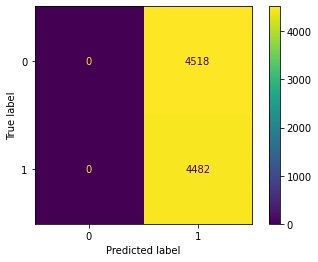

In [ ]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, train_data.sentiment)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate on train,dev, and test subsets
predictions_train = baseline.predict(x_train_tfidf)
score = accuracy_score(train_data.sentiment, predictions_train)
print("Train accuracy: {:.2f}% \n".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(dev_data.sentiment, predictions_dev)
print("Dev accuracy: {:.2f}% \n".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(test_data.sentiment, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(train_data.sentiment == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(train_data.sentiment == 1)[0].shape)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf, y_true=test_data.sentiment, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Dummy Classifier')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Dummy Classifier

Train
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     17487
           1       0.50      1.00      0.67     17513

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.33     35000


Dev
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2995
           1       0.50      1.00      0.67      3005

    accuracy                           0.50      6000
   macro avg       0.25      0.50      0.33      6000
weighted avg       0.25      0.50      0.33      6000


Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4518
           1       0.50      1.00      0.66      4482

    accuracy                           0.50      9000
   macro avg       0.25      0.50      0.33      9000
weighted avg       0.25      0.50      

In [ ]:
#Roc scores
print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

Training AUC score =  0.5
Dev AUC score =  0.5
Test AUC score =  0.5


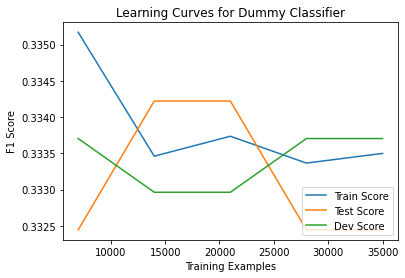

In [ ]:
F1_Curves(DummyClassifier(),'Dummy Classifier')

##### Logistic Regression (2nd Baseline)

In [ ]:
# Train // Approx 5 minutes
#Grid for Grid Search
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

clf = LogisticRegression(solver="saga")
clf_cv=GridSearchCV(clf,grid,cv=pds,scoring=f1)
start_time = time.time()
clf_cv.fit(x_param_tfidf, y_param)
print("tuned hyperparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)
print("Training took: {} seconds \n".format(time.time() - start_time))

tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.8914944270332107
Training took: 364.31441354751587 seconds 



Train f1-score: 91.25%

Dev f1-score: 88.00% 

Test f1-score: 87.67% 


Confusion Matrix for test data:


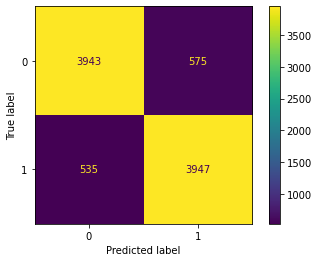

In [ ]:
#Train using the best parameters from Grid Search
clf = LogisticRegression(C=clf_cv.best_params_['C'],penalty=clf_cv.best_params_['penalty'], solver='saga' )
clf.fit(x_train_tfidf, y_train)

# Evaluate on train,dev, and test subsets 
predictions_train = clf.predict(x_train_tfidf)
predictions_proba_train=clf.predict_proba(x_train_tfidf)
score = f1_score(y_train,predictions_train)
print("Train f1-score: {:.2f}%\n".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
predictions_proba_dev=clf.predict_proba(x_dev_tfidf)
score = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}% \n".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
predictions_proba_test=clf.predict_proba(x_test_tfidf)
score = f1_score(y_test, predictions_test)
print("Test f1-score: {:.2f}% \n".format(score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Logistic Regression')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Logistic Regression

Train
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     17487
           1       0.91      0.92      0.91     17513

    accuracy                           0.91     35000
   macro avg       0.91      0.91      0.91     35000
weighted avg       0.91      0.91      0.91     35000


Dev
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2995
           1       0.87      0.89      0.88      3005

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000


Test
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4518
           1       0.87      0.88      0.88      4482

    accuracy                           0.88      9000
   macro avg       0.88      0.88      0.88      9000
weighted avg       0.88      0.88   

In [ ]:
# #Area Under the Curve score

# print('Training AUC score = ',roc_auc_score(y_train,predictions_train))
# print('Dev AUC score = ',roc_auc_score(y_dev,predictions_dev))
# print('Test AUC score = ',roc_auc_score(y_test,predictions_test))

In [ ]:
#Setting up seaborne pallete
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

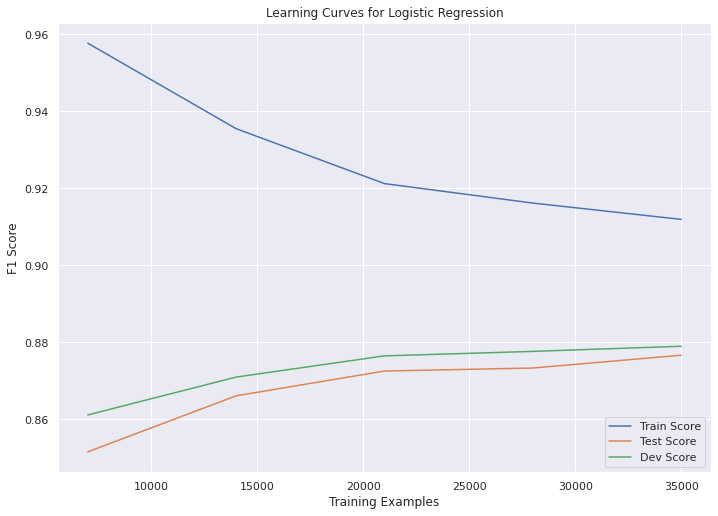

In [ ]:
F1_Curves(LogisticRegression(C=clf_cv.best_params_['C'],penalty=clf_cv.best_params_['penalty'], solver='saga'),"Logistic Regression")

In [ ]:
from sklearn.metrics import precision_recall_curve


#Training AUC for the 2 Classes
p,r,t = precision_recall_curve(y_train,predictions_proba_train[:,1])
positive_area=auc(r,p)
print(positive_area)

p2,r2,t2 = precision_recall_curve(1-y_train,predictions_proba_train[:,0])
negative_area=auc(r2,p2)
print(negative_area)

#Dev AUC for the 2 Classes
p3,r3,t3 = precision_recall_curve(y_dev,predictions_proba_dev[:,1])
positive_area2=auc(r3,p3)
print(positive_area2)

p4,r4,t4 = precision_recall_curve(1-y_dev,predictions_proba_dev[:,0])
negative_area2=auc(r4,p4)
print(negative_area2)


#Test AUC for the 2 Classes
p5,r5,t5 = precision_recall_curve(y_test,predictions_proba_test[:,1])
positive_area3=auc(r5,p5)
print(positive_area3)

p6,r6,t6 = precision_recall_curve(1-y_test,predictions_proba_test[:,0])
negative_area3=auc(r6,p6)
print(negative_area3)

0.9703958575382997
0.9719373998475249
0.9514774504330864
0.9556773205488178
0.9449373812941626
0.9514542323461967


##### Neural Net

###### Hyperparameter Tuning(Keras Tuner)

In [ ]:
def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(2500,)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 3
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 1, 3)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0.1, 0.5, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Tune learning rate for Adam optimizer with values from  0.001, or 0.0001/We run the loop for bigger learning rate values but it was too time consuming
    #and we only kept the 2 best learning values for further development of our model.
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [ ]:
# # Instantiate the tuner
# #The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model
# tuner = kt.Hyperband(build_model,
#                      #Metric which will be used for the hyperparameter tuning
#                      objective="val_accuracy",
#                      max_epochs=20,
#                      #Reduction factor for the number of epochs and number of models for each bracket.
#                      factor=3,
#                      hyperband_iterations=10,
#                      directory="kt_dir",
#                      project_name="kt_hyperband3",)

In [ ]:
NUM_EPOCHS=20
# tuner.search_space_summary()

In [ ]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# #Tuning
# tuner.search(x_train_tfidf, y_train, epochs=NUM_EPOCHS, validation_data=(x_dev_tfidf.todense(),y_dev), callbacks=[stop_early], verbose=2)

In [ ]:
# # Get the optimal hyperparameters from the results
# best_hps=tuner.get_best_hyperparameters()[0]

# # Build model
# h_model = tuner.hypermodel.build(best_hps)

# # Train the hypertuned model
# h_model.fit(x_train_tfidf, y_train, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [ ]:
# #Checking model summary
# h_model.summary()

In [ ]:
# #Classifying with our model
# predictions_test = h_model.predict(x_test_tfidf.todense())
# #Calculating F1 score
# score = f1_score(y_test, np.round(predictions_test))

# print("Test f1-score: {:.2f}% \n".format(score*100))
# print(confusion_matrix(y_test, np.round(predictions_test)))

In [ ]:
# #Plotting confusion matrix
# cm = confusion_matrix(y_test, np.round(predictions_test))
# f = sns.heatmap(cm, annot=True, fmt='d')

###### Building the model manually(Efficient)

In [ ]:
#As we are not able to run the tuning process everytime because it is too time consuming,we've stored the keras model information so as to build it from scratch.
#Define the keras model
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(2500,)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
#Compiling the keras model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=1e-4), metrics=['accuracy'])
#Fitting the keras model on the dataset
history = model.fit(x_train_tfidf, y_train, epochs=NUM_EPOCHS, validation_data=(x_dev_tfidf.todense(),y_dev), callbacks=[stop_early], verbose=2)
#Evaluating the keras model
acc = model.evaluate(x_train_tfidf, y_train)
print('Accuracy: %.2f' % (acc[1]*100))

Epoch 1/20
1094/1094 - 8s - loss: 0.4376 - accuracy: 0.8131 - val_loss: 0.2767 - val_accuracy: 0.8860 - 8s/epoch - 7ms/step
Epoch 2/20
1094/1094 - 4s - loss: 0.2633 - accuracy: 0.8919 - val_loss: 0.2691 - val_accuracy: 0.8852 - 4s/epoch - 4ms/step
Epoch 3/20
1094/1094 - 4s - loss: 0.2441 - accuracy: 0.8994 - val_loss: 0.2724 - val_accuracy: 0.8835 - 4s/epoch - 4ms/step
Epoch 4/20
1094/1094 - 4s - loss: 0.2331 - accuracy: 0.9058 - val_loss: 0.2759 - val_accuracy: 0.8825 - 4s/epoch - 4ms/step
1094/1094 [==============================] - 4s 3ms/step - loss: 0.2037 - accuracy: 0.9219
Accuracy: 92.19


In [ ]:
#Classifying with our model
predictions_test = model.predict(x_test_tfidf.todense())

#Calculating F1 score
score = f1_score(y_test, np.round(predictions_test))

print("Test f1-score: {:.2f}% \n".format(score*100))
print(confusion_matrix(y_test, np.round(predictions_test)))

Test f1-score: 88.07% 

[[3961  557]
 [ 517 3965]]


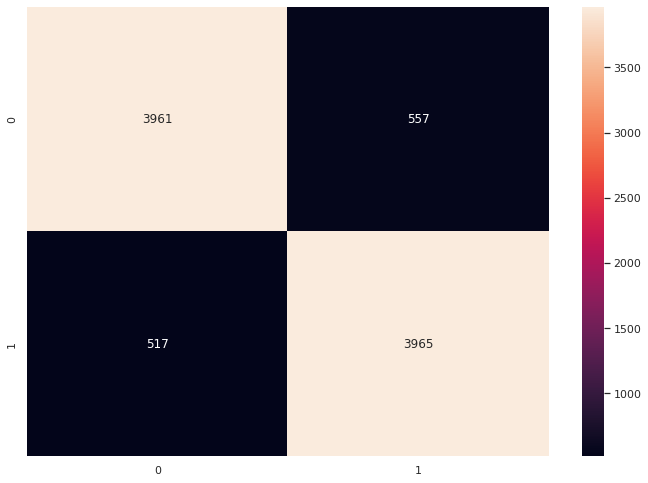

In [ ]:
#Plotting confusion matrix
cm = confusion_matrix(y_test, np.round(predictions_test))
f = sns.heatmap(cm, annot=True, fmt='d')

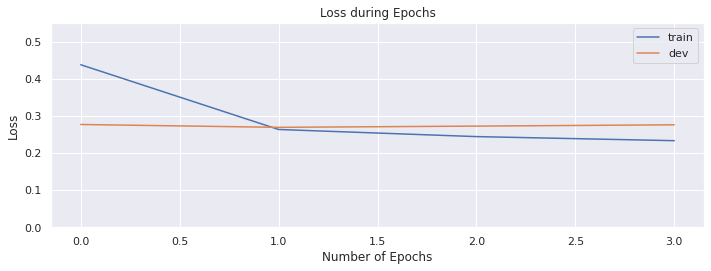

In [ ]:
import matplotlib.pyplot as pyplot
#Plot loss during training/Manually adjusted patience to stop at 4 epochs
pyplot.subplot(211)
plt.ylim((0,0.55))
plt.title('Loss during Epochs')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='dev')
pyplot.legend();

In [ ]:
#Classification Report on train,dev,test datasets.
print('Logistic Regression')
print('')
print('Train')
print(classification_report(y_train,np.round(model.predict(x_train_tfidf))))
print('')
print('Dev')
print(classification_report(y_dev,np.round(model.predict(x_dev_tfidf.todense()))))
print('')
print('Test')
print(classification_report(y_test,np.round(predictions_test)))

Logistic Regression

Train
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     17487
           1       0.91      0.93      0.92     17513

    accuracy                           0.92     35000
   macro avg       0.92      0.92      0.92     35000
weighted avg       0.92      0.92      0.92     35000


Dev
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2995
           1       0.88      0.89      0.88      3005

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000


Test
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4518
           1       0.88      0.88      0.88      4482

    accuracy                           0.88      9000
   macro avg       0.88      0.88      0.88      9000
weighted avg       0.88      0.88   

In [ ]:

#Training AUC for the 2 Classes
p,r,t = precision_recall_curve(y_train,model.predict(x_train_tfidf))
positive_area=auc(r,p)
print('Train Positive',positive_area)

p2,r2,t2 = precision_recall_curve(1-y_train,1-model.predict(x_train_tfidf))
negative_area=auc(r2,p2)
print('Train Negative',negative_area)

#Dev AUC for the 2 Classes
p3,r3,t3 = precision_recall_curve(y_dev,model.predict(x_dev_tfidf.todense()))
positive_area2=auc(r3,p3)
print('Dev Positive',positive_area2)

p4,r4,t4 = precision_recall_curve(1-y_dev,1-model.predict(x_dev_tfidf.todense()))
negative_area2=auc(r4,p4)
print('Dev Negative',negative_area2)


#Test AUC for the 2 Classes
p5,r5,t5 = precision_recall_curve(y_test,model.predict(x_test_tfidf.todense()))
positive_area3=auc(r5,p5)
print('Test Positive',positive_area3)

p6,r6,t6 = precision_recall_curve(1-y_test,1-model.predict(x_test_tfidf.todense()))
negative_area3=auc(r6,p6)
print('Test Negative',negative_area3)

Train Positive 0.9744574708918998
Train Negative 0.9756553027198278
Dev Positive 0.952860731351516
Dev Negative 0.9574023540298116
Test Positive 0.9474909950335628
Test Negative 0.9538314922134267


In [ ]:
# #Area Under the Curve score

# print('Training AUC score = ',roc_auc_score(y_train,np.round(model.predict(x_train_tfidf))))
# print('Dev AUC score = ',roc_auc_score(y_dev,np.round(model.predict(x_dev_tfidf.todense()))))
# print('Test AUC score = ',roc_auc_score(y_test,predictions_test))